<a href="https://colab.research.google.com/github/tadasi12/dev/blob/master/fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# initial

In [5]:
# 必要なパッケージを取得
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Colabratory用の認証トークンの生成
# 以下のコードを実行すると認証のリンクが表示され、リンク先に行って認証を行います。
from google.colab import auth
auth.authenticate_user()

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110845 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [6]:
# Drive FUSE library用の証明書の生成
# 以下のコードを実行すると認証のリンクが表示され、リンク先で認証を行います。
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Google Drive をマウントする
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


## import

In [2]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import SGD
from keras.callbacks import CSVLogger
import os, glob
from keras.utils import np_utils

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
import random
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
batch_size = 32
num_classes = 2
epochs = 500
num_dataset = 1700


save_dir = 'drive/Colab Notebooks/starbucks/'
model_name = 'keras_cifar10_trained_model.h5'
w, h = 128, 128
img_path = 'drive/Colab Notebooks/starbucks/img/'

## load dataset

In [8]:
def load_datasete(path, classnum, X, Y, w, h):

    for file in tqdm(random.sample(glob.glob(path+'*.???'), num_dataset)):
        img = img_to_array(load_img(file, target_size=(h,w)))

        X.append(img)
        Y.append(classnum)


X = []
Y = []

# 対象Aの画像
load_datasete(img_path+'stab/', 0, X, Y, w, h)

# 対象Bの画像
load_datasete(img_path+'mac/', 1, X, Y, w, h)


# arrayに変換
X = np.asarray(X)
Y = np.asarray(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0,)

X_train /= 255.0
X_test /= 255.0
# 1 of Kのベクトルに変換
# y_train = np_utils.to_categorical(y_train, num_classes)
# y_test = np_utils.to_categorical(y_test, num_classes)

100%|██████████| 1700/1700 [16:03<00:00,  1.57it/s]


In [0]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [6]:
len(X_train)

2380

# network

## fine tune

In [9]:
# base_model=VGG16(weights='imagenet',include_top=False, input_tensor=Input(shape=X_train.shape[1:]))
base_model=VGG16(weights='imagenet',include_top=False, input_tensor=Input(shape=(128,128,3)))

#add new layers instead of FC networks
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
prediction=Dense(1, activation='sigmoid')(x)
model=Model(inputs=base_model.input,outputs=prediction)

#fix weights before VGG16 14layers
for layer in base_model.layers[:15]:
    layer.trainable=False

58892288/58889256 [==============================] - 6s 0us/step


In [34]:
    vgg16_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=X_train.shape[1:]))
    # vgg16_model.summary()

    # FC層を構築
    # Flattenへの入力指定はバッチ数を除く
    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    # 学習済みのFC層の重みをロード
#     top_model.load_weights(os.path.join(result_dir, 'bottleneck_fc_model.h5'))

    # vgg16_modelはkeras.engine.training.Model
    # top_modelはSequentialとなっている
    # ModelはSequentialでないためadd()がない
    # そのためFunctional APIで二つのモデルを結合する
    # https://github.com/fchollet/keras/issues/4040
    model = Model(input=vgg16_model.input, output=top_model(vgg16_model.output))
    
    for layer in model.layers[:15]:
        layer.trainable = False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [106]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
# model.add(Dense(1))
model.add(Activation('softmax'))
# model.add(Activation('sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
activation_53 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_54 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 63, 63, 64)        18496     
__________

## compile

In [0]:
# initiate RMSprop optimizer
# opt = keras.optimizers.rmsprop(lr=1e-4, decay=1e-6)
opt = keras.optimizers.SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
# opt = keras.optimizers.SGD(lr=1e-3, momentum=0.9)

# Let's train the model using RMSprop
# model.compile(loss='categorical_crossentropy',
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

# fpath = 'weights.{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5'
cp_cb = keras.callbacks.ModelCheckpoint(save_dir+model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# training

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
validation_split=0.0)

datagen.fit(X_train)

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test),
                    callbacks=[cp_cb],
                    workers=4)

Epoch 1/500
75/75 [==============================] - 20s 264ms/step - loss: 0.6996 - acc: 0.4989 - val_loss: 0.7034 - val_acc: 0.4706

Epoch 00001: val_loss improved from inf to 0.70337, saving model to drive/Colab Notebooks/starbucks/keras_cifar10_trained_model.h5
Epoch 2/500
75/75 [==============================] - 14s 183ms/step - loss: 0.6989 - acc: 0.4861 - val_loss: 0.7008 - val_acc: 0.4833

Epoch 00002: val_loss improved from 0.70337 to 0.70077, saving model to drive/Colab Notebooks/starbucks/keras_cifar10_trained_model.h5
Epoch 3/500
75/75 [==============================] - 14s 183ms/step - loss: 0.6976 - acc: 0.4913 - val_loss: 0.6989 - val_acc: 0.4863

Epoch 00003: val_loss improved from 0.70077 to 0.69895, saving model to drive/Colab Notebooks/starbucks/keras_cifar10_trained_model.h5
Epoch 4/500
75/75 [==============================] - 14s 182ms/step - loss: 0.6965 - acc: 0.4901 - val_loss: 0.6972 - val_acc: 0.4922

Epoch 00004: val_loss improved from 0.69895 to 0.69718, sav

In [0]:
def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

# 学習履歴

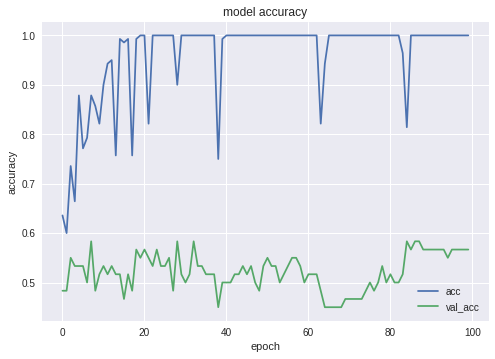

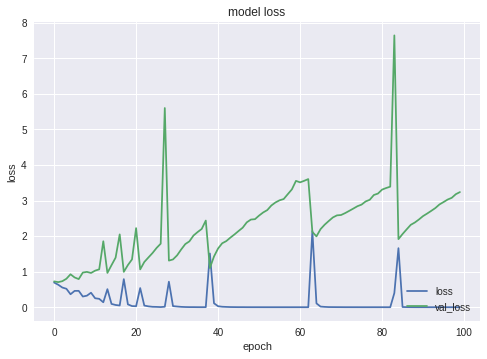

In [19]:
# 学習履歴をプロット
plot_history(history)

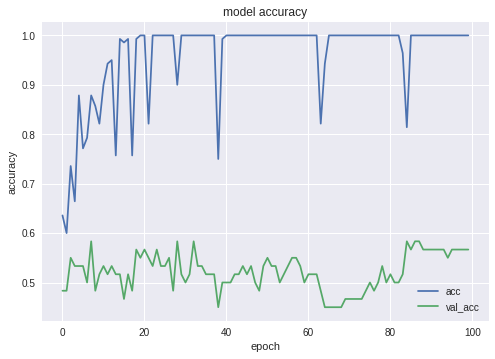

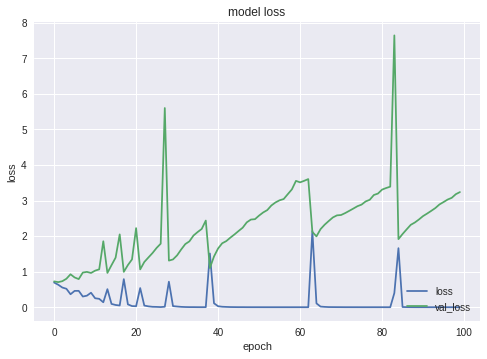

In [22]:
# 学習履歴をプロット
plot_history(history)

## sgd

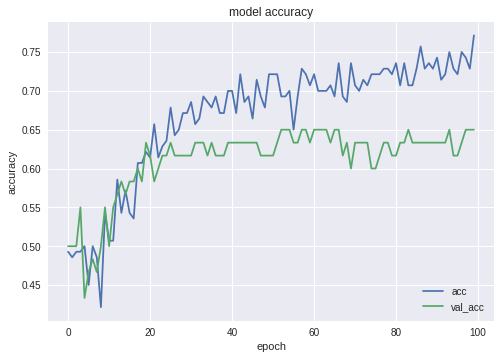

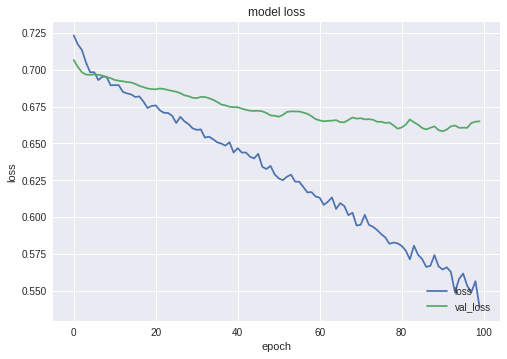

In [14]:
# 学習履歴をプロット
plot_history(history)

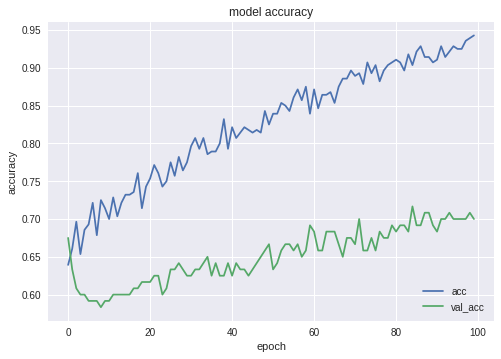

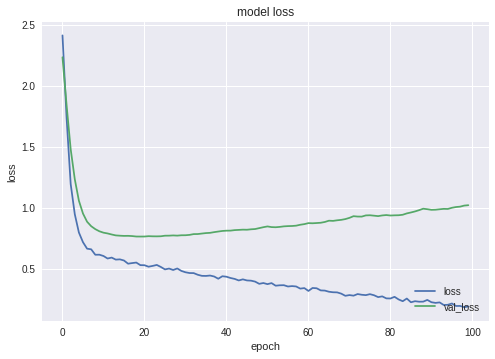

In [25]:
# 学習履歴をプロット
plot_history(history)

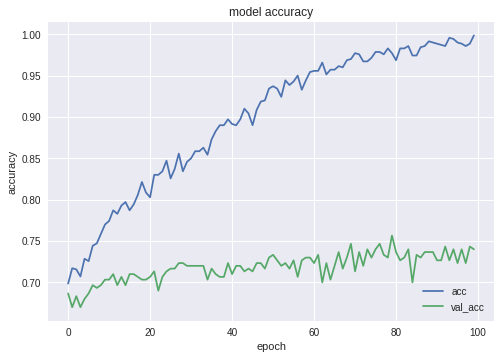

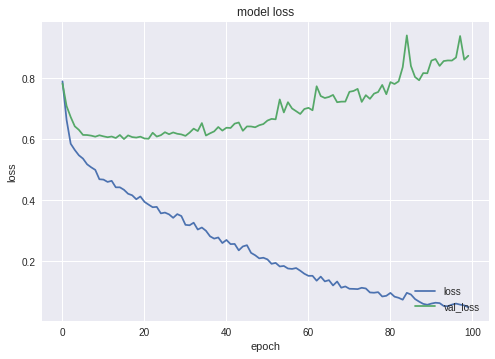

In [29]:
# 学習履歴をプロット
plot_history(history)

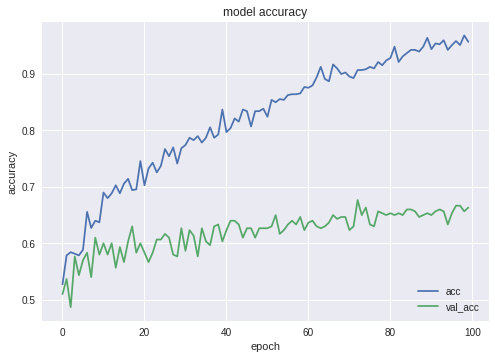

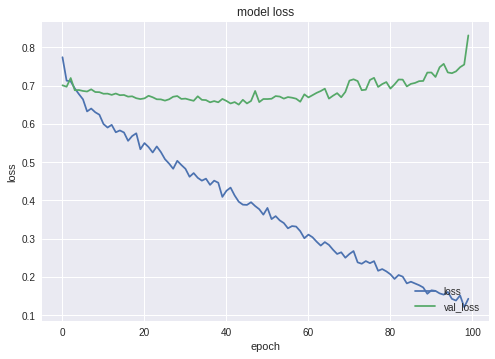

In [38]:
# 学習履歴をプロット
plot_history(history)

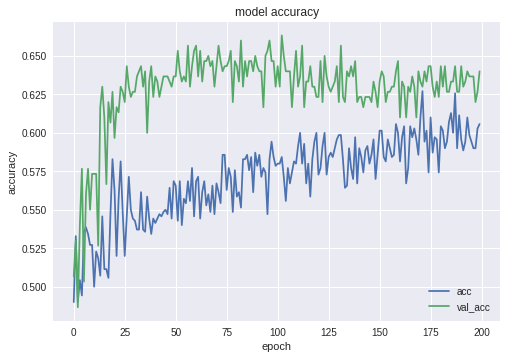

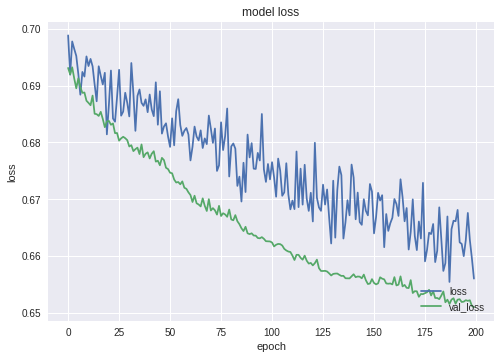

In [61]:
# 学習履歴をプロット
plot_history(history)

# Resnet

In [0]:
import sys
sys.path.append('drive/Colab Notebooks/starbucks')

In [0]:
from keras.callbacks import ReduceLROnPlateau
import resnet

In [0]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

batch_size = 32
nb_classes = 2
epoch = 200

# input image dimensions
img_rows, img_cols = 128, 128
# The CIFAR10 images are RGB.
img_channels = 3

In [73]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 64, 64, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 64, 64, 64)   256         conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 64, 64, 64)   0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
max_poolin

In [13]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    validation_data=(X_test, y_test),
                    epochs=epoch, verbose=1, max_queue_size=100,
                    shuffle=True,
                    callbacks=[lr_reducer])

NameError: ignored

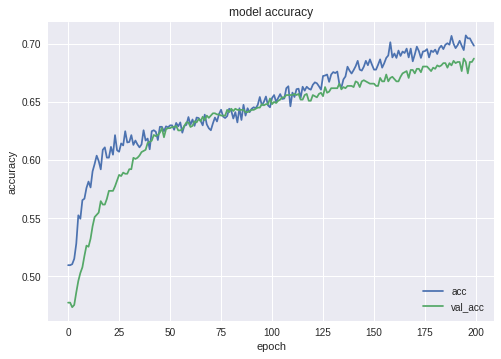

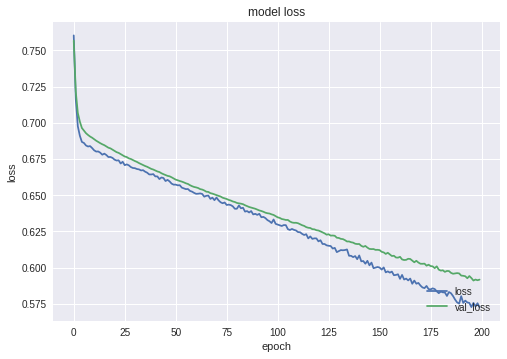

In [9]:
# 学習履歴をプロット
plot_history(history)

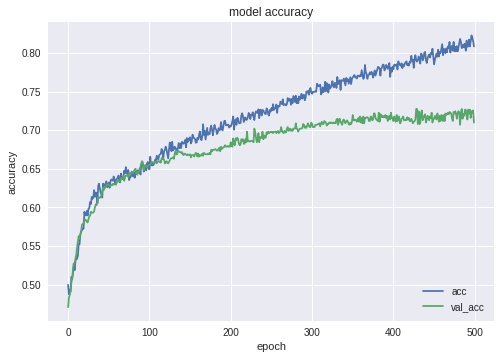

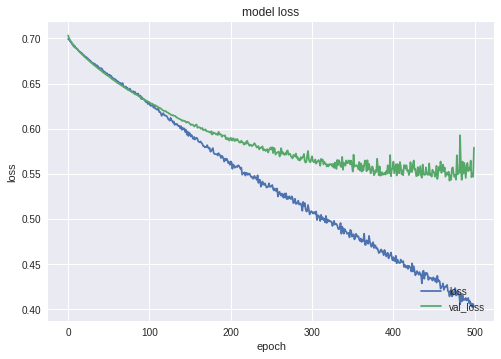

In [13]:
# 学習履歴をプロット
plot_history(history)

In [86]:
len(X_train)

2100

# テスト

In [37]:
model = keras.models.load_model(save_dir+'keras_fine_tune_trained_model.h5', compile=False)
model.predict(np.array([X_test[0]]), verbose=1)

1/1 [==============================] - 1s 756ms/step


array([[0.11636228]], dtype=float32)

In [1]:
!ls

sample_data


In [1]:
len(X_train)

NameError: ignored